In [42]:
# imports 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time
import logging
import matplotlib.ticker as ticker
import math


# configs
pd.options.display.max_rows = 4000
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None # supress wanrnings
pd.set_option('display.max_columns', 500)

# import file
# Reading data 
loans_df = pd.read_csv('loan.csv', engine="python")
display(loans_df.head())



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,nan,nan,3,0,13648,83.70%,9,f,0.00,0.00,5863.16,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,nan,1,INDIVIDUAL,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
1,1077430,1314167,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,nan,nan,3,0,1687,9.40%,4,f,0.00,0.00,1008.71,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,nan,1,INDIVIDUAL,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
2,1077175,1313524,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,nan,nan,2,0,2956,98.50%,10,f,0.00,0.00,3005.67,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,nan,1,INDIVIDUAL,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,nan,nan,nan,nan
3,1076863,1277178,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.00,nan,10,0,5598,21%,37,f,0.00,0.00,12231.89,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,nan,1,INDIVIDUAL,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,

In [43]:
# original shape
print("Original Shape :" + loans_df.shape.__str__())

# removing all null columns
null_columns = loans_df.isnull().mean() == 1
loans_df_cleaned = loans_df.loc[:,null_columns.values != True]

# removing column where all values are same
unique_column = loans_df_cleaned.nunique() == 1 
loans_df_cleaned = loans_df_cleaned.loc[: , unique_column.values != True]

# removing  duplicate rows
loans_df_cleaned = loans_df_cleaned.drop_duplicates()
# no such row was detected
# all rows are unique

# listing all columns as per https://www.investopedia.com/terms/f/five-c-credit.asp , 5cs of credit risk analysis
# 5c risk analysis + personal monetary info + other variables
risk_analysis = {
    "character": ["delinq_2yrs", "earliest_cr_line", "inq_last_6mths", "inq_last_12m", "open_acc", "total_acc","revol_bal", "revol_util", "pub_rec_bankruptcies"],
    "capacity":["annual_inc", "verification_status", "dti"],
    "capital":[],
    "collateral":[],
    "condition":["loan_amnt", "funded_amnt", 
                 "funded_amnt_inv", "term", "int_rate", "installment", "grade" , "sub_grade",
                 "purpose",  ],
    "personal": ["emp_title", "emp_length", "home_ownership", "mths_since_last_delinq", "mths_since_last_record"],
    "other": ["issue_d", "loan_status", "desc" , "zip_code", "addr_state", "pub_rec", ],
    "current_status": ["out_prncp", "out_prncp_inv", "total_pymnt", 
                       "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
                      "recoveries", "collection_recovery_fee", "last_credit_pull_d", "next_pymnt_d", "last_credit_pull_d", 'last_pymnt_d', 'last_pymnt_amnt']
    
}

# combining all variables of risk analysis 
risk_analysis_agg = set([value for category in risk_analysis for value in risk_analysis[category]])

# dropping 'url', 'member_id', 'id', 'title' 
columns_to_drop = set(loans_df_cleaned.columns) - risk_analysis_agg
loans_df_cleaned = loans_df_cleaned.drop(columns_to_drop, axis=1)

# cleaning int_rate by making it a continuous variable
loans_df_cleaned['int_rate']=loans_df_cleaned['int_rate'].str.rstrip('%').astype(np.float_)
print("Updated Shape :" + loans_df_cleaned.shape.__str__())


Original Shape :(39717, 111)
Updated Shape :(39717, 44)


### Analysis

In [44]:
# describing data to understand it's spread
# retrieving quantitative variables

continuous_variables = loans_df_cleaned.select_dtypes(include=np.number).columns.tolist()
continuous_variables.append('int_rate')


summary = loans_df_cleaned.describe()
# adding median to summary matrix
summary.loc["median"] =  loans_df_cleaned.median()
summary.loc["mode"] = loans_df_cleaned.mode().transpose()[0]
summary = summary.round(2)


### printing summary matrix
display(summary.transpose().round(2))



,count,mean,std,min,25%,50%,75%,max,median,mode
loan_amnt,39717.00,11219.44,7456.67,500.00,5500.00,10000.00,15000.00,35000.00,10000.00,10000.00
funded_amnt,39717.00,10947.71,7187.24,500.00,5400.00,9600.00,15000.00,35000.00,9600.00,10000.00
funded_amnt_inv,39717.00,10397.45,7128.45,0.00,5000.00,8975.00,14400.00,35000.00,8975.00,5000.00
int_rate,39717.00,12.02,3.72,5.42,9.25,11.86,14.59,24.59,11.86,10.99
installment,39717.00,324.56,208.87,15.69,167.02,280.22,430.78,1305.19,280.22,311.11
annual_inc,39717.00,68968.93,63793.77,4000.00,40404.00,59000.00,82300.00,6000000.00,59000.00,60000.00
dti,39717.00,13.32,6.68,0.00,8.17,13.40,18.60,29.99,13.40,0.00
delinq_2yrs,39717.00,0.15,0.49,0.00,0.00,0.00,0.00,11.00,0.00,0.00
inq_last_6mths,39717.00,0.87,1.07,0.00,0.00,1.00,1.00,8.00,1.00,0.00
mths_since_last_delinq,14035.00,35.90,22.02,0.00,18.00,34.00,52.00,120.00,34.00,0.00


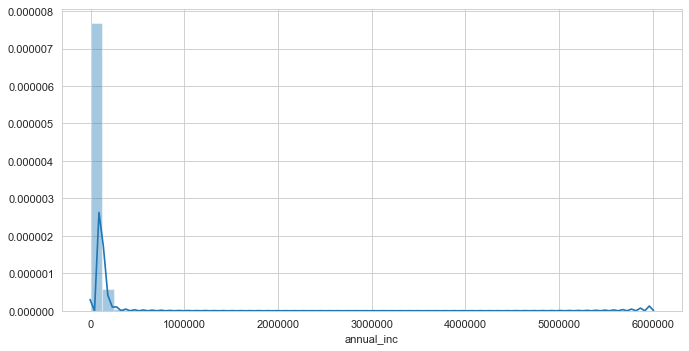

In [45]:
# studying spread of annual income to see outliers

sns.set_style('whitegrid')
plt.figure(num=None,figsize=(10,5),dpi=80)

loan_incomePlot = sns.distplot(loans_df_cleaned['annual_inc'])

plt.show()


#### Above graph points out that annual_inc has outliers . We will now check Quantile value to clean up our data.

In [46]:
print(loans_df_cleaned['annual_inc'].quantile(0.95))
print(loans_df_cleaned['annual_inc'].quantile(0.99).round(2))

142000.0
234999.36


In [47]:
# removing outliers beyound 99%
loans_df_cleaned = loans_df_cleaned[loans_df_cleaned["annual_inc"] < loans_df_cleaned['annual_inc'].quantile(0.99)]
loans_df_cleaned['annual_inc'].describe()

summary = loans_df_cleaned.loc[:,continuous_variables].describe()
# adding median to summary matrix
summary.loc["median"] =  loans_df_cleaned.loc[:,continuous_variables].median()
summary.loc["mode"] = loans_df_cleaned.loc[:,continuous_variables].mode().transpose()[0]
summary = summary.round(2)
display(summary['annual_inc'].transpose())


count     39319.00
mean      65524.22
std       35215.89
min        4000.00
25%       40000.00
50%       58000.00
75%       81000.00
max      234996.00
median    58000.00
mode      60000.00
Name: annual_inc, dtype: float64

In [48]:
### Type Metric ###
def extract_datetime(df, column):
    # splits column to month and year
    # column_month 
    # column_year 
    data = df[column].str.split('-', 1, expand=True)
    df[column + '_month'] = data[0]
    df[column + '_year'] = data[1]
    
    return df
    


loans_df_cleaned = extract_datetime(loans_df_cleaned, 'issue_d')
loans_df_cleaned = extract_datetime(loans_df_cleaned, 'last_pymnt_d')
#loan_df_cleaned_no_outlier = extract_datetime(loan_df_cleaned_no_outlier, 'next_pymnt_d')
loans_df_cleaned = extract_datetime(loans_df_cleaned, 'last_credit_pull_d')


    

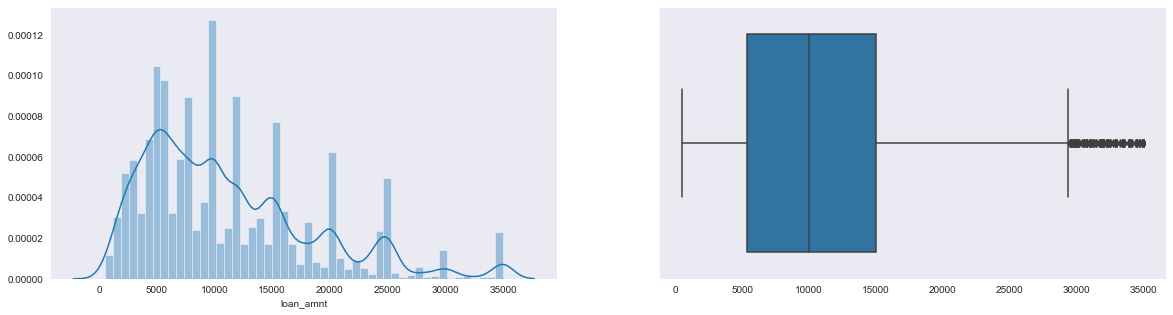

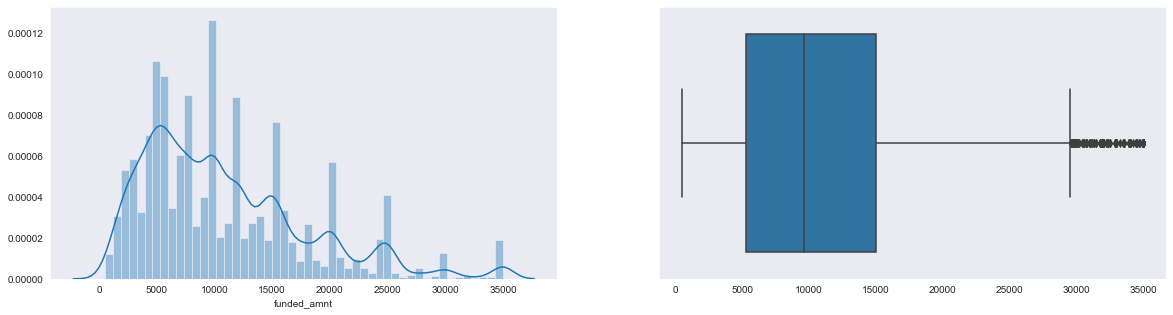

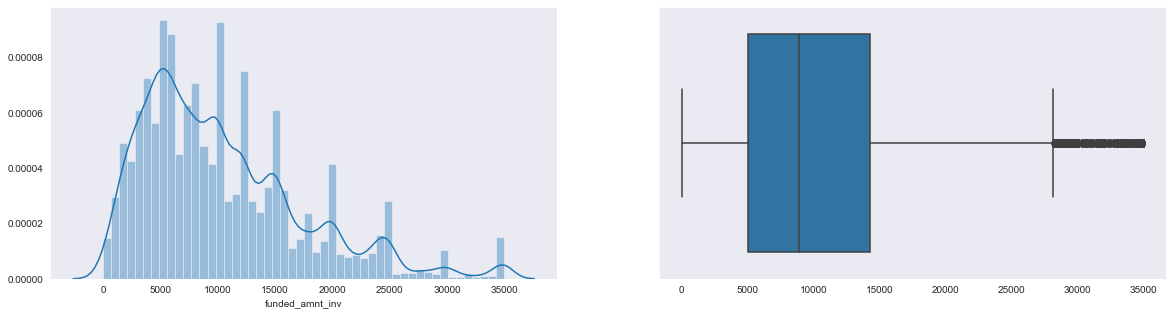

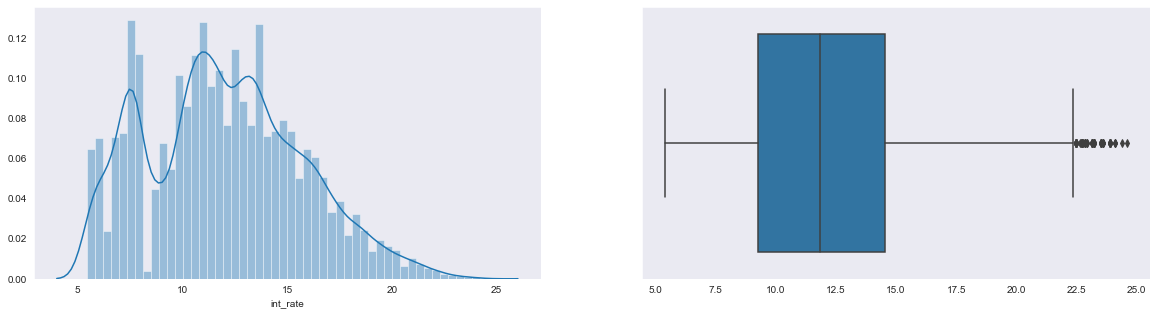

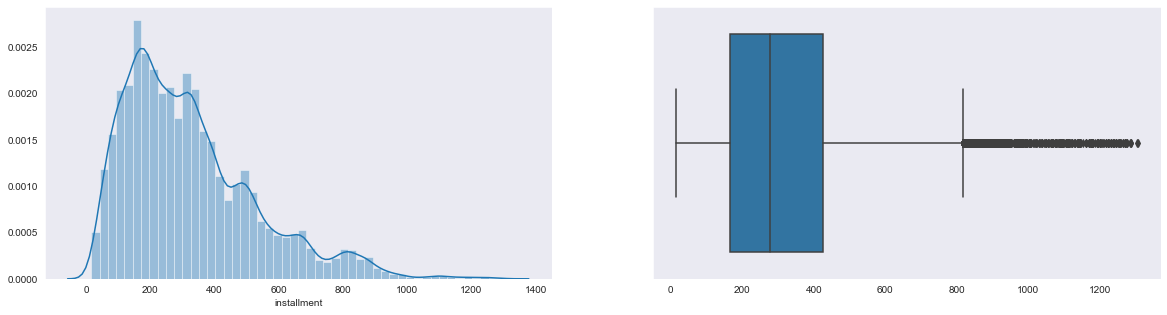

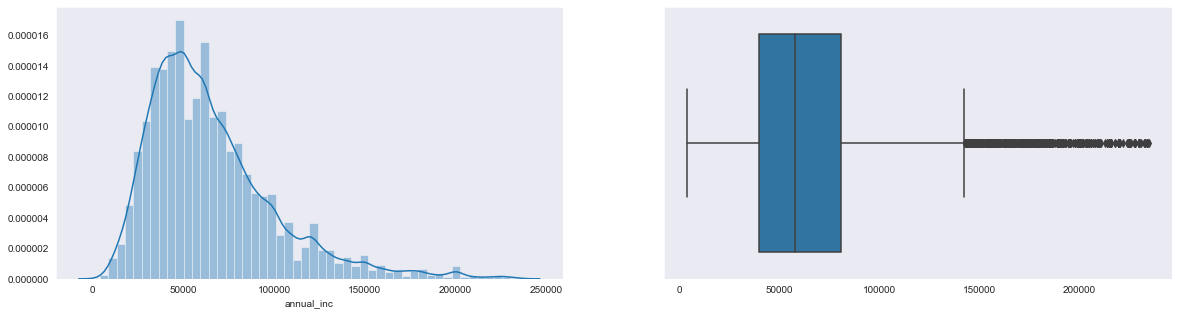

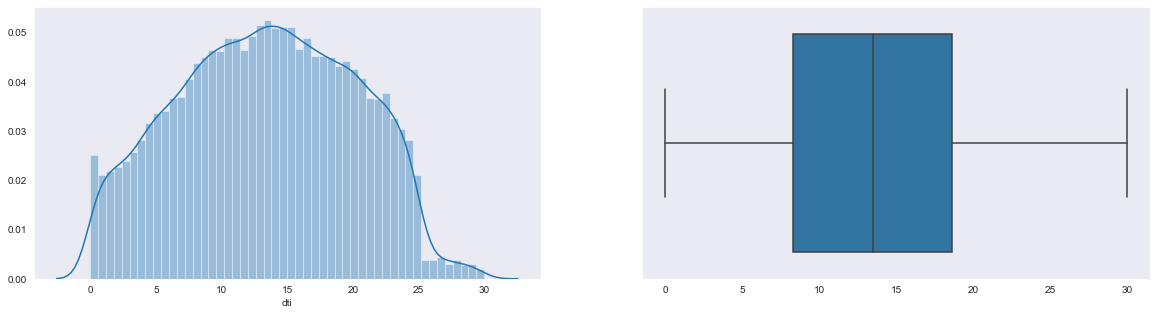

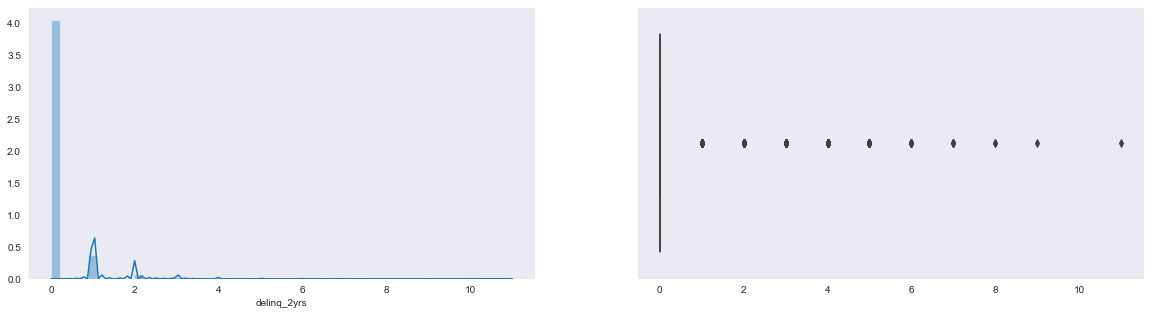

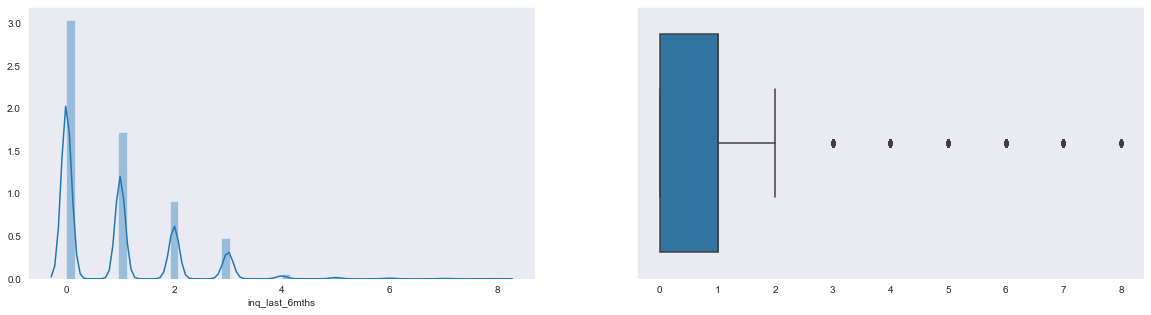

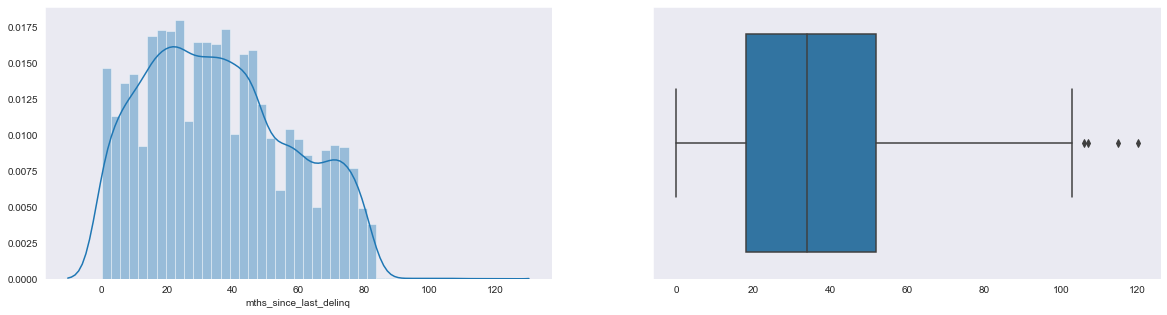

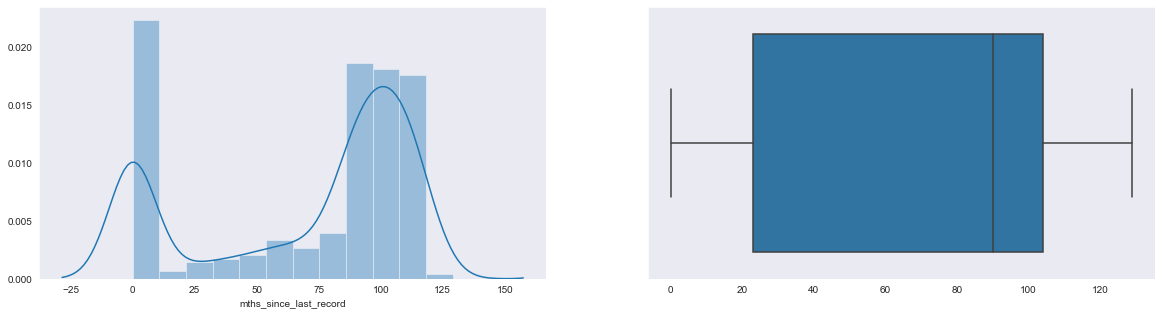

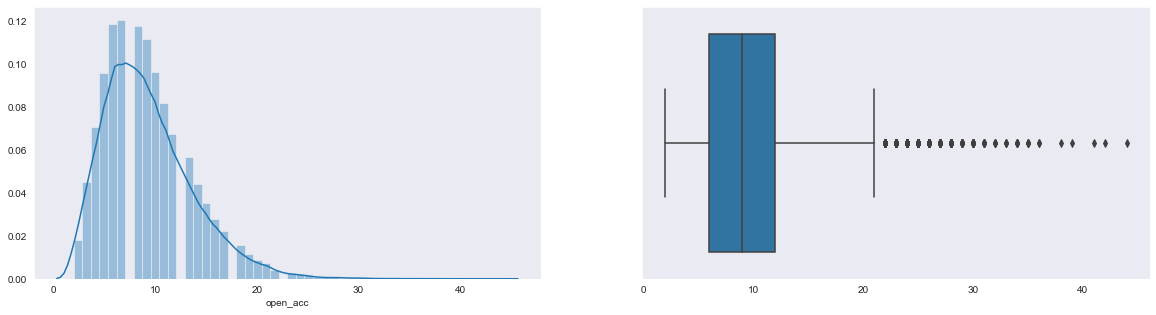

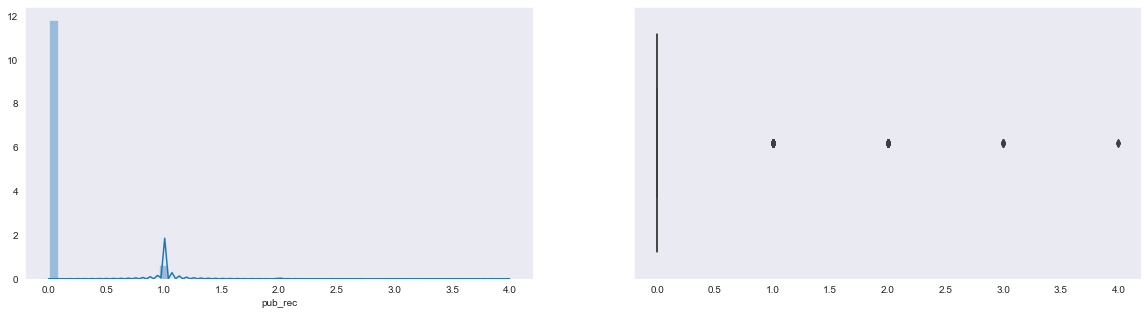

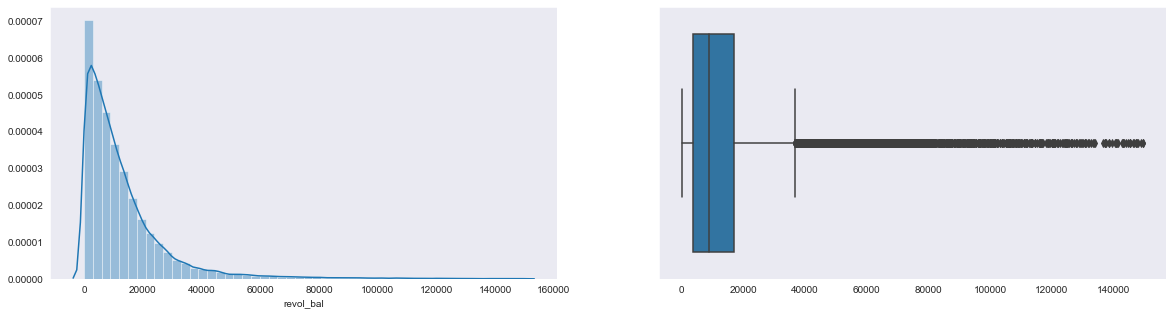

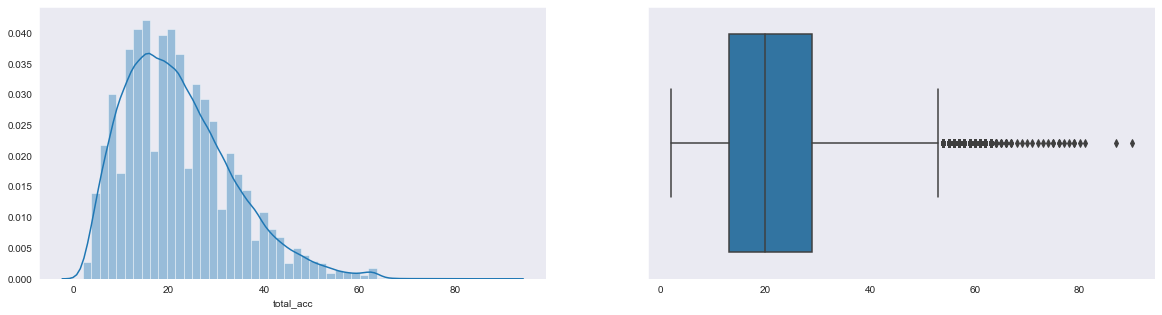

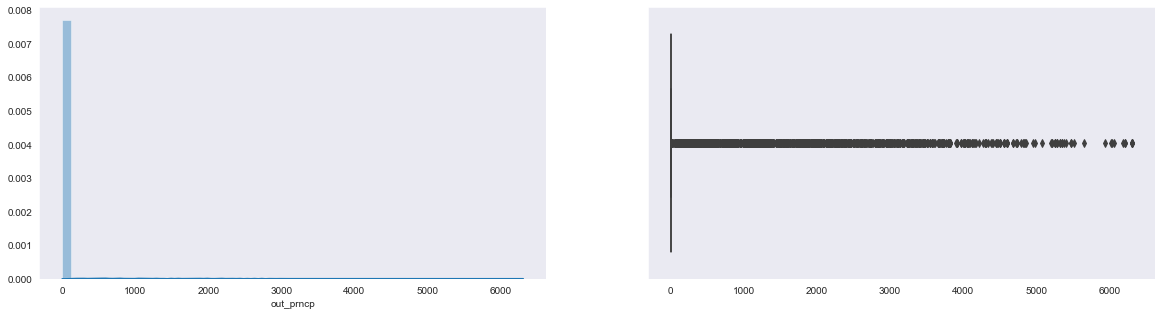

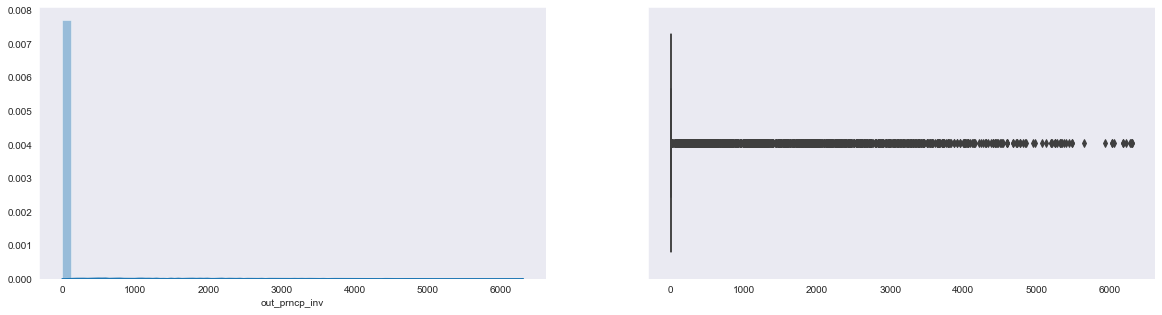

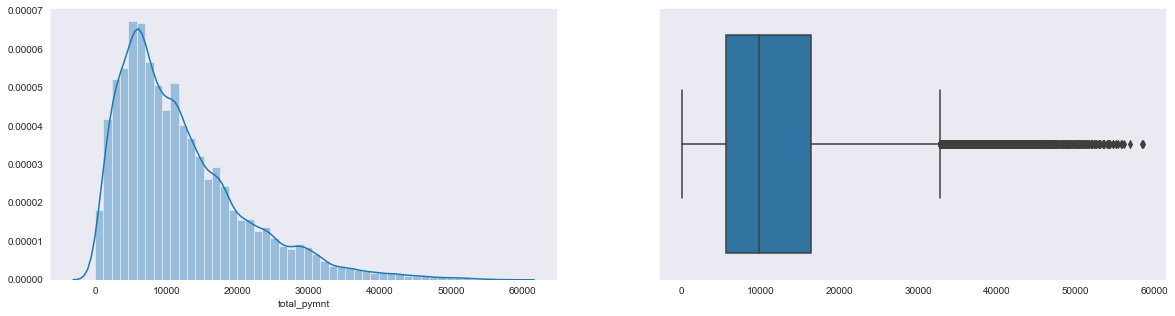

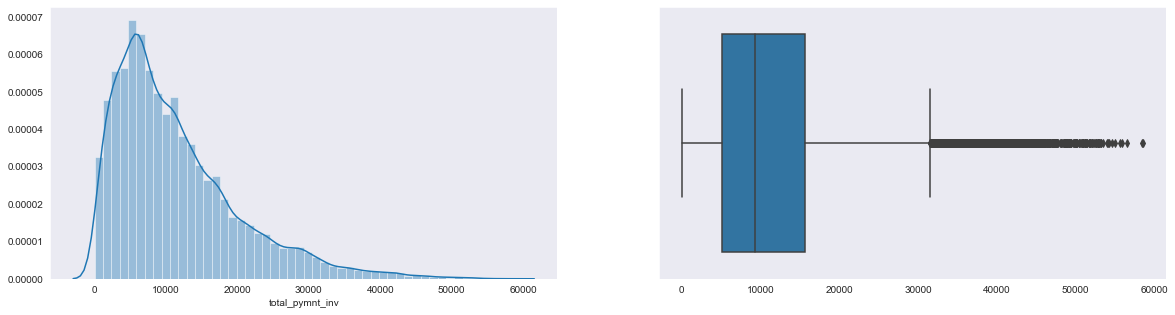

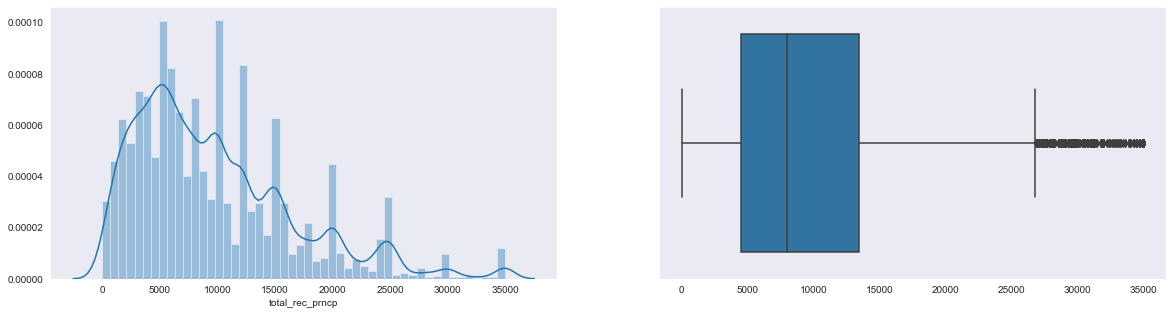

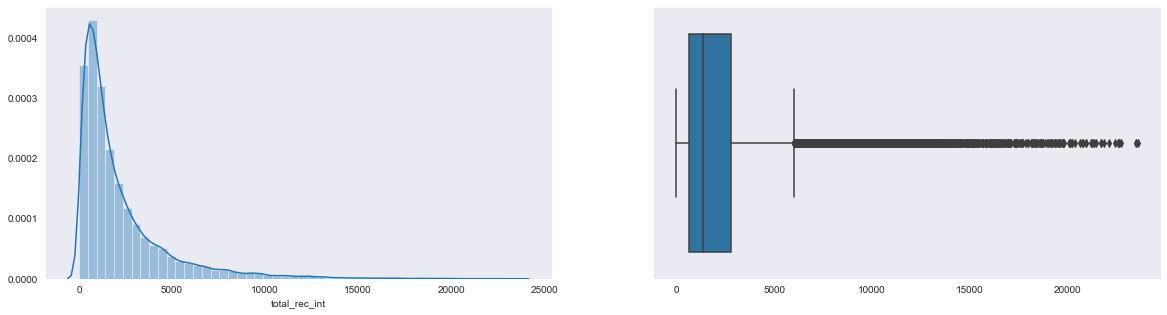

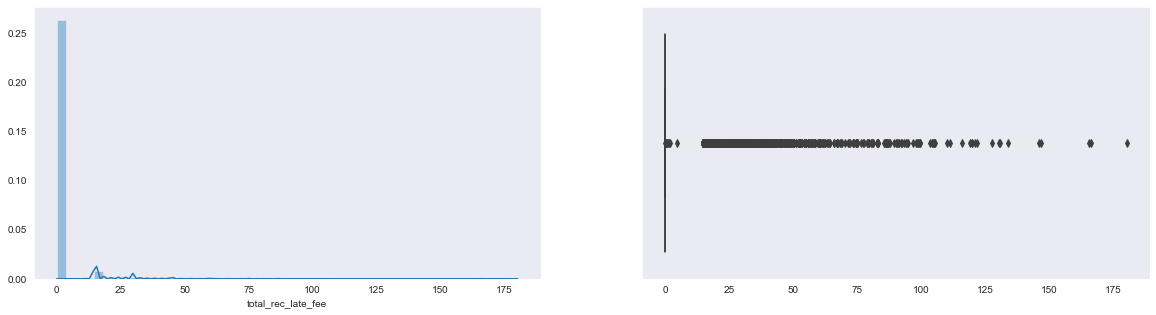

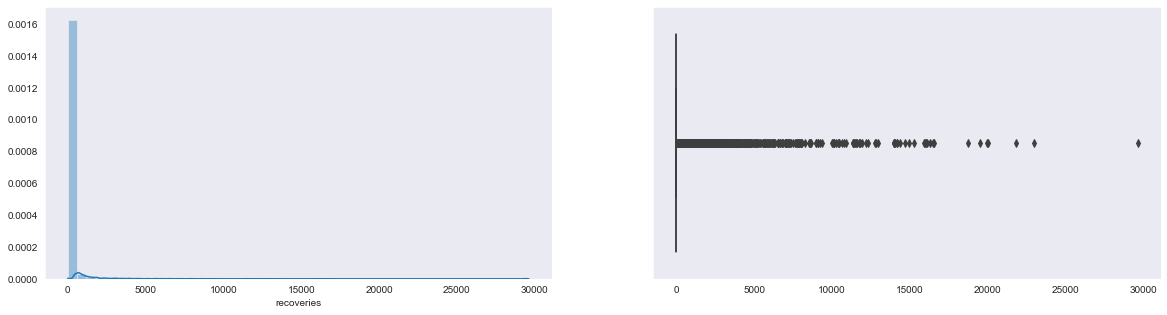

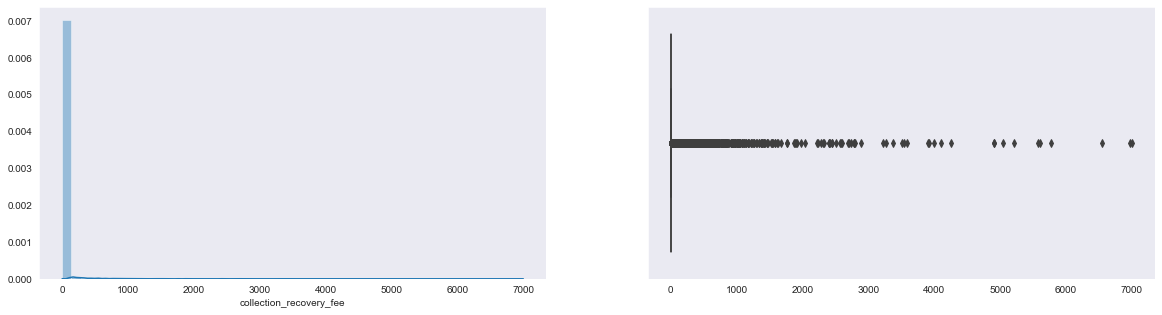

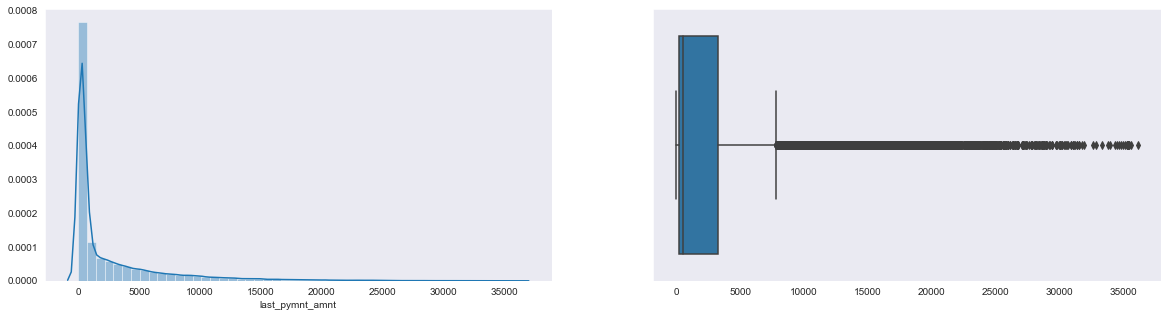

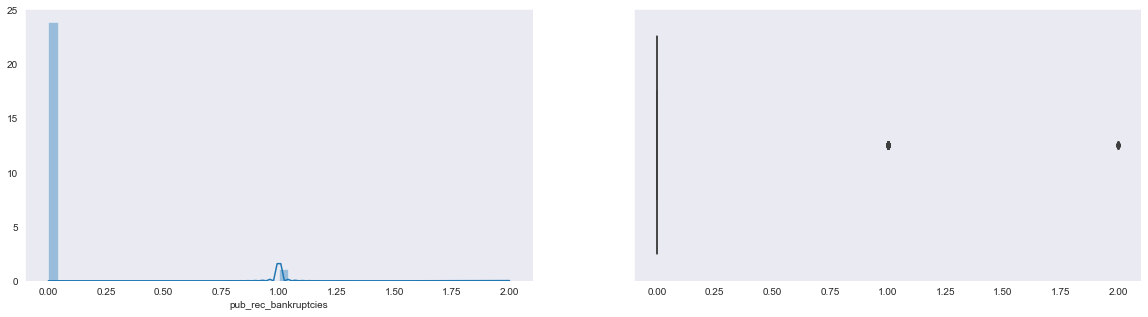

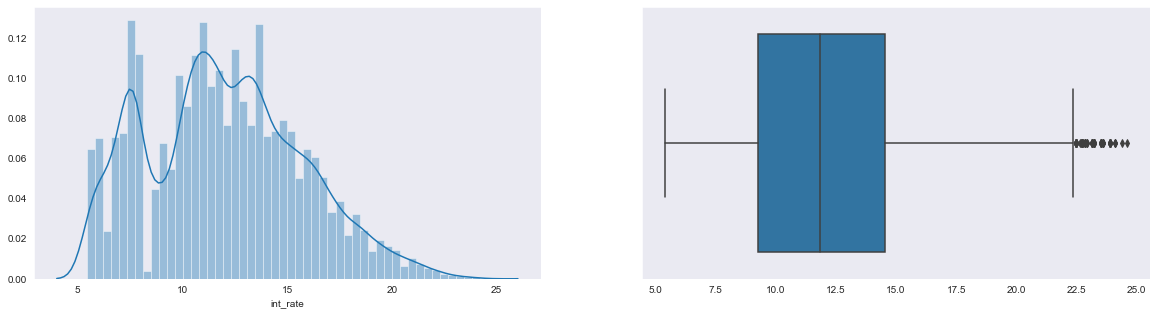

In [49]:
sns.set_style("dark")
def analysis_univariate_quant(df, variable):
    fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(20, 5))
    
    sns.distplot(pd.DataFrame(df[variable].values).dropna(), ax=ax[0], kde=True, rug=False, hist=True, axlabel=variable)
    sns.boxplot(x=df[variable].values, ax=ax[1])
    #plt.suptitle(title)
    
# doing a quick iteration to identify key columns for univariate analysis
for variable in continuous_variables:
    
    fig, ax = plt.subplots(nrows=1,  ncols=2, figsize=(20, 5))
    
    mean = round(loans_df_cleaned[variable].mean())
    
    vertical_offset = mean * 0.05 # offset from mean for display
    
    
    sns.distplot(pd.DataFrame(loans_df_cleaned[variable]).dropna().values, ax=ax[0], kde=True, rug=False, hist=True, axlabel=variable)
    
    boxplot1 = sns.boxplot(x=loans_df_cleaned[variable].values, ax=ax[1])
        
    plt.show()

#### Loan Amount

,count,mean,std,min,25%,50%,75%,max,median,mode
loan_amnt,39319.00,11134.11,7376.09,500.00,5400.00,10000.00,15000.00,35000.00,10000.00,10000.00


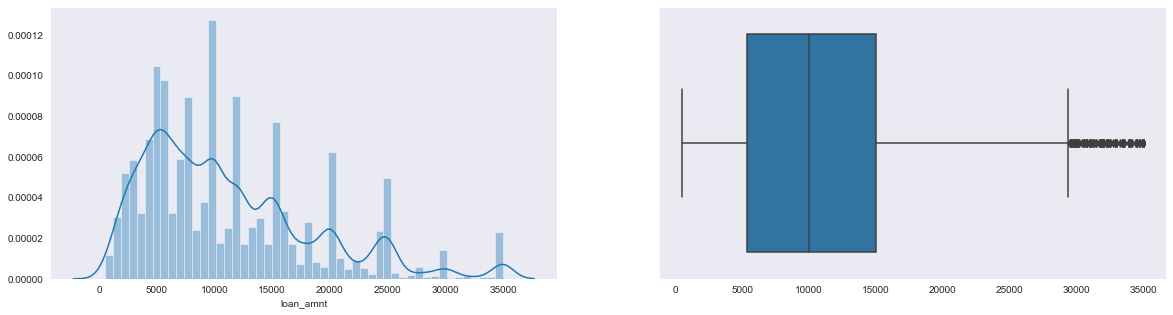

In [50]:
### observations from univariate analysis of quantitative variable

#1) loan amount
summary_loan_amount = summary.loc[:,['loan_amnt']].transpose()
display(summary_loan_amount)

analysis_univariate_quant(loans_df_cleaned, 'loan_amnt')

# maximum values lie in the first half of the plot , 
# both boxplots and loan amount confirms the same

#### Funded Amount

,count,mean,std,min,25%,50%,75%,max,median,mode
funded_amnt,39319.00,10865.96,7108.68,500.00,5300.00,9600.00,15000.00,35000.00,9600.00,10000.00


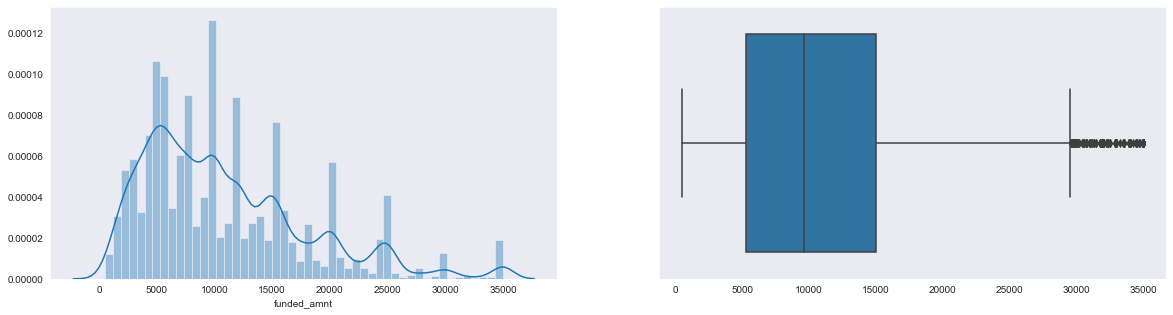

In [51]:
#2  funded amount
summary_funded_amnt = summary.loc[:,['funded_amnt']].transpose()
display(summary_funded_amnt)

analysis_univariate_quant(loans_df_cleaned, 'funded_amnt')

# maximum values lie in the first half of the plot , both boxplots and loan amount confirms the same
# also it seems that the amount commited to loan follows the same trend as the loan applied. This might turn out 
# to be a good analysis for bivariate analysis


# skipping funded_amnt_inv and installment since the trend is almost as some as funded_amnt

#### annual_inc

,count,mean,std,min,25%,50%,75%,max,median,mode
annual_inc,39319.00,65524.22,35215.89,4000.00,40000.00,58000.00,81000.00,234996.00,58000.00,60000.00


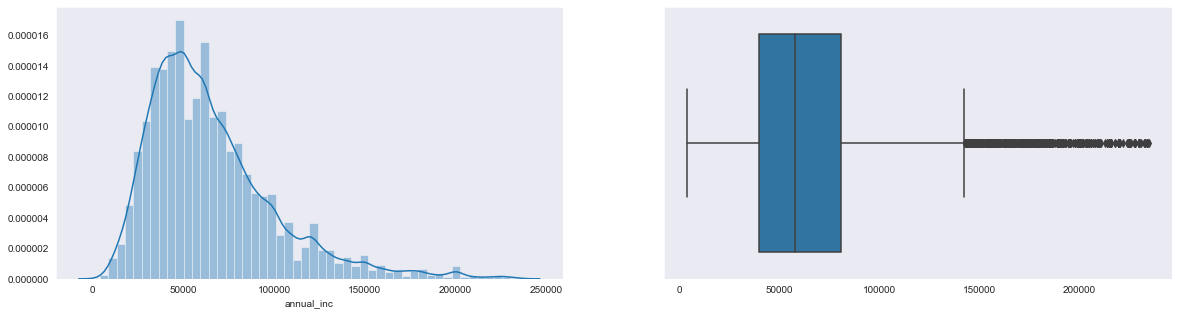

In [52]:
#3  annual_inc
summary_funded_inc_annual = summary.loc[:,['annual_inc']].transpose()
display(summary_funded_inc_annual)

analysis_univariate_quant(loans_df_cleaned , 'annual_inc')


###### This data points out that majority of the people who applied for loan have annual income around 100000 USD 

#### dti

,count,mean,std,min,25%,50%,75%,max,median,mode
dti,39319.00,13.38,6.66,0.00,8.27,13.48,18.64,29.99,13.48,0.00


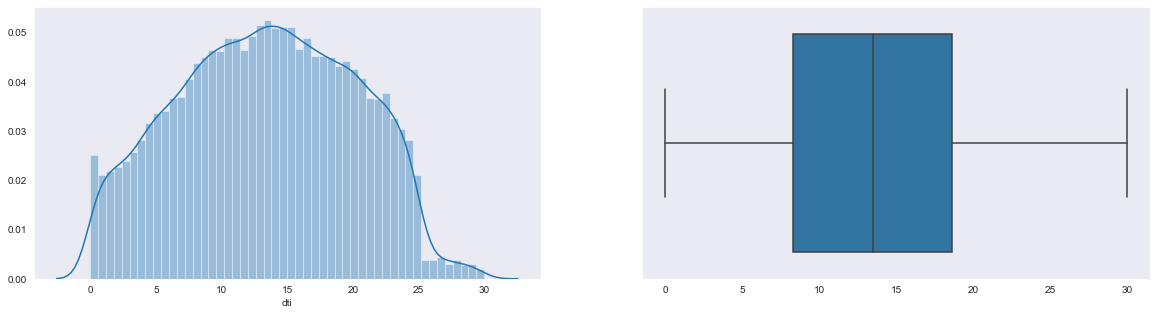

In [53]:
# 4) dti

summary_dti = summary.loc[:,['dti']].transpose()
display(summary_dti)

analysis_univariate_quant(loans_df_cleaned, 'dti')

## debt to income follows a normal curve and the values are highest in the center around 15 

###### debt to income follows a normal curve with mean 13.33 .

,count,mean,std,min,25%,50%,75%,max,median,mode
mths_since_last_delinq,13875.00,35.95,22.02,0.00,18.00,34.00,52.00,120.00,34.00,0.00


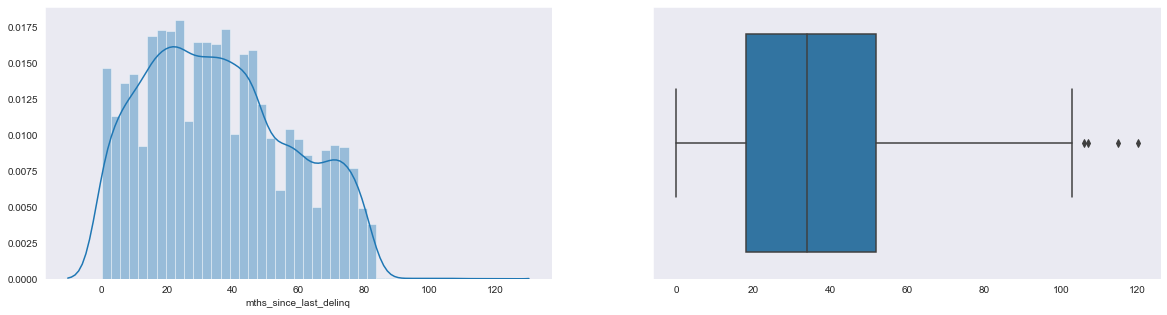

In [54]:
# 5) mths_since_last_delinq

summary_mths_since_last_delinq = summary.loc[:,['mths_since_last_delinq']].transpose()
display(summary_mths_since_last_delinq)

analysis_univariate_quant(loans_df_cleaned, 'mths_since_last_delinq')

# 



# plotting of univariates proves the efficiency of using IQR for removing outliers . 





#### Categorical Data

In [55]:
non_quantitative_variable = set(loans_df_cleaned.columns.values) - set(continuous_variables)
ordered_variables = ['grade', 'emp_length', 'last_pymnt_d', 'next_pymnt_d', 'sub_grade', 'loan_status']


In [56]:
def categroical_analysis(df1, variable):
    fig, ax = plt.subplots(nrows=1,  ncols=1, figsize=(20, 5))
    
    sns.countplot(data=df1, x=variable)
  
    

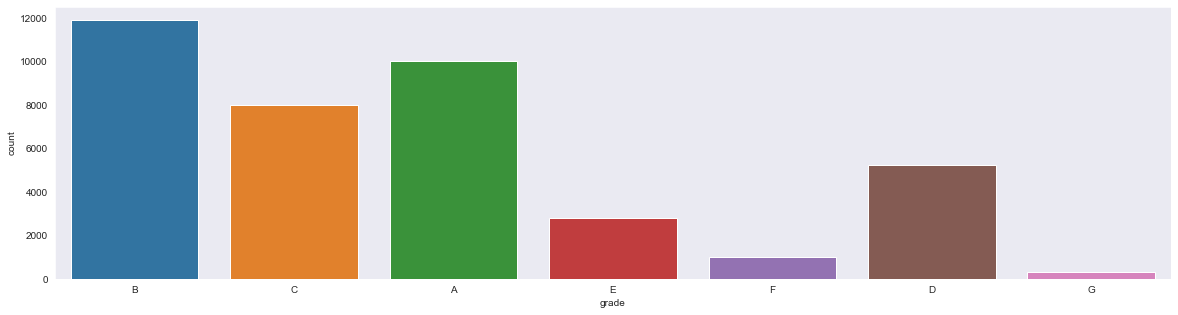

In [57]:
categroical_analysis(loans_df_cleaned, 'grade')

### grade b has the highest count

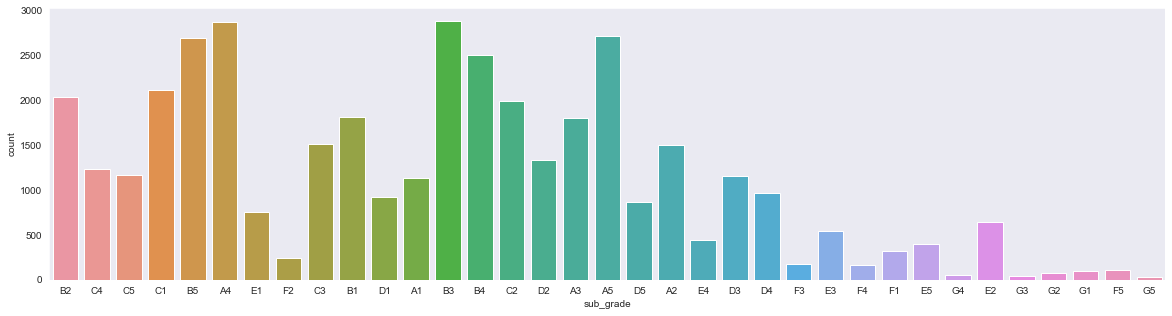

In [58]:
categroical_analysis(loans_df_cleaned, 'sub_grade')

### whereas in subgrades A4, A5 & B3 have the highest count

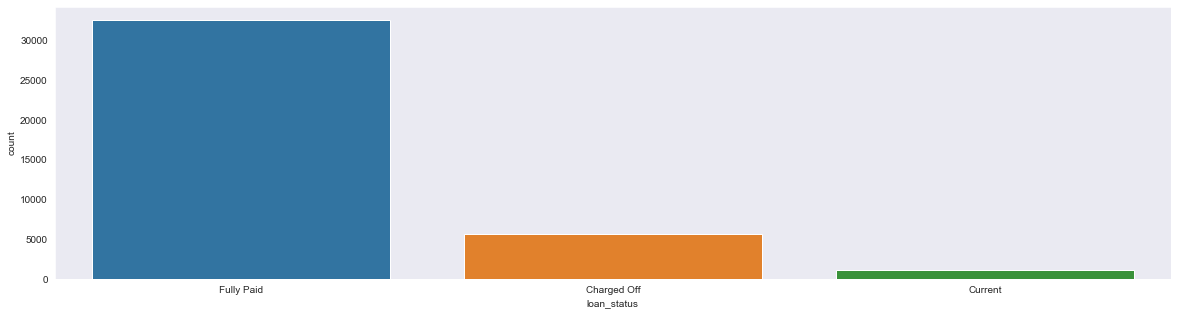

In [59]:
categroical_analysis(loans_df_cleaned, 'loan_status')

### number of instances of charged off  are higher than current

In [60]:
#### plotting all category data for quick summary


# for variable in non_quantitative_variable:
    
#     ### analyzing if any plot follows power graph for variable greater than 5
#     try:
#         categroical_analysis(loans_df_cleaned, variable)
#     except:
#         print(variable)
#     ### 
    
# graphs involved do not follow power law

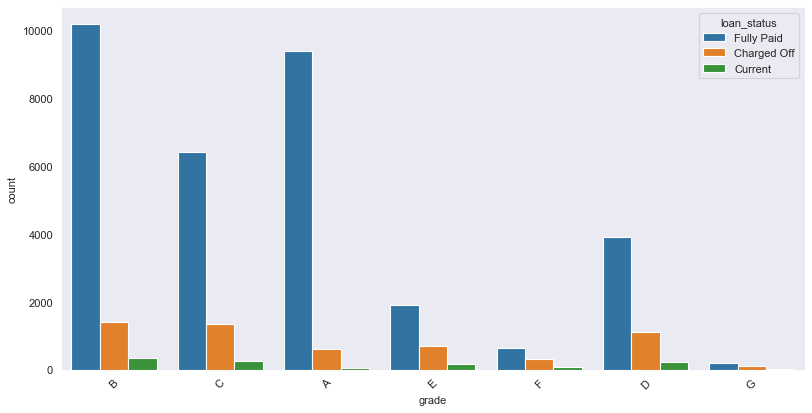

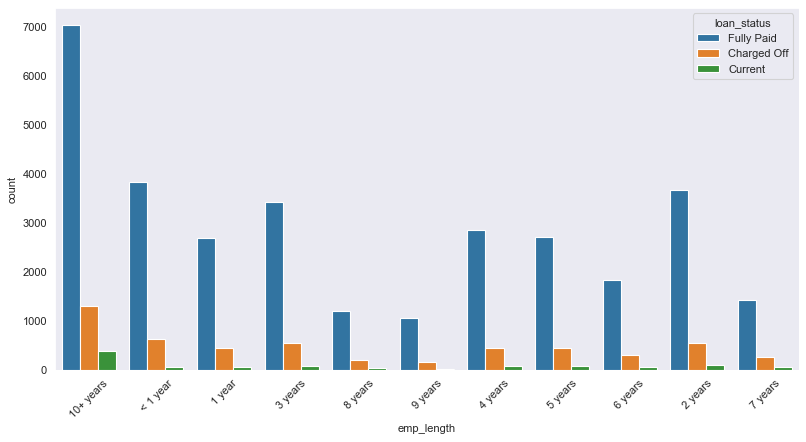

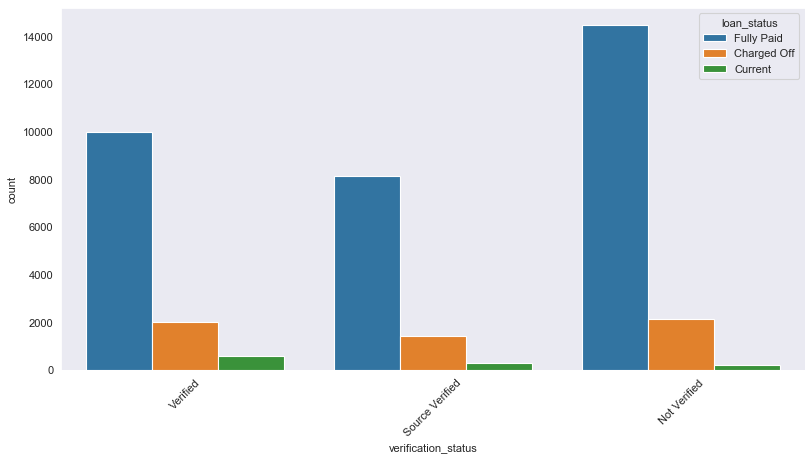

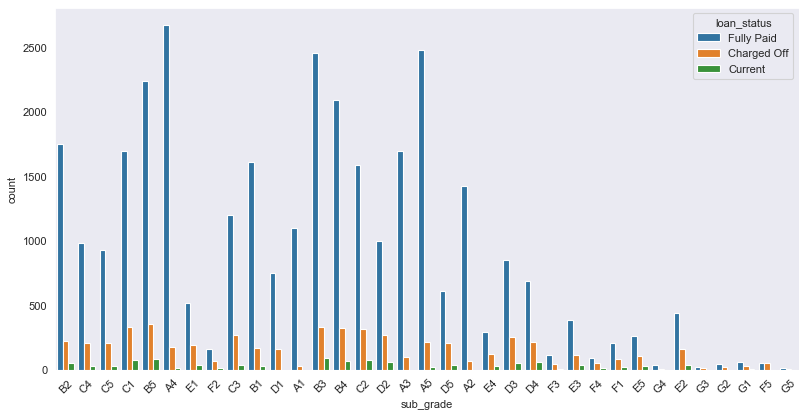

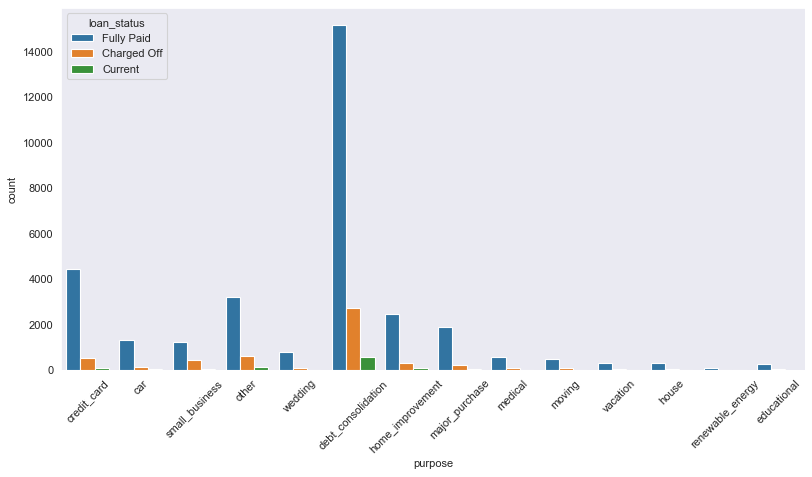

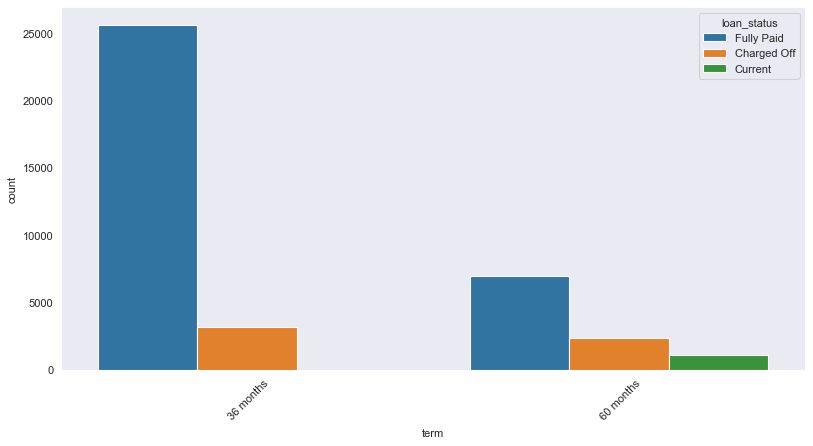

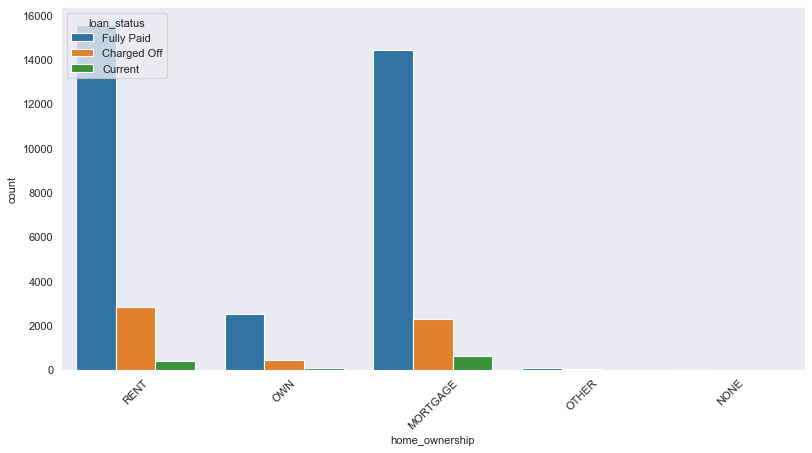

In [61]:
# Getting status wrt to type/purpose of loan


# loan_purpose_plot = sns.countplot(x="purpose", hue="loan_status", data=loans_df_cleaned)
# loan_purpose_plot.set_xticklabels(loan_purpose_plot.get_xticklabels(), rotation=45)

# plt.show()


qa = ["grade", "emp_length",
      "verification_status", "sub_grade", "purpose", "term", "home_ownership"]
for variable in qa:
    plt.figure(num=None,figsize=(12,6),dpi=80)
    loan_purpose_plot = sns.countplot(x=variable, hue="loan_status", data=loans_df_cleaned)
    loan_purpose_plot.set_xticklabels(loan_purpose_plot.get_xticklabels(), rotation=45)
    
    plt.show()



#### 1)Higher the grade (ascending order in alphabetic order) , higher is the loan applications. 
#### 2)10+ years emp_length group has higher number of loans .
#### 3)Majority of loan taken was for debt consolidation . 
#### 4)Majority of people are opting for 36 months loan.
#### 5)People with home_ownership status as Mortgage and Rent have higher loan count . 
#### Probably , people with mortgage are taking up loan to clear existing one .

In [62]:
CorrData = loans_df_cleaned.loc[:, ['loan_amnt','funded_amnt','funded_amnt_inv','int_rate','installment','annual_inc','dti','out_prncp']]
CorrMatrix= CorrData.corr()
CorrMatrix


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,out_prncp
loan_amnt,1.00,0.98,0.94,0.31,0.93,0.42,0.08,0.19
funded_amnt,0.98,1.00,0.96,0.31,0.96,0.41,0.08,0.20
funded_amnt_inv,0.94,0.96,1.00,0.30,0.90,0.39,0.08,0.20
int_rate,0.31,0.31,0.30,1.00,0.28,0.07,0.11,0.13
installment,0.93,0.96,0.90,0.28,1.00,0.41,0.06,0.13
annual_inc,0.42,0.41,0.39,0.07,0.41,1.00,-0.11,0.06
dti,0.08,0.08,0.08,0.11,0.06,-0.11,1.00,0.04
out_prncp,0.19,0.20,0.20,0.13,0.13,0.06,0.04,1.00


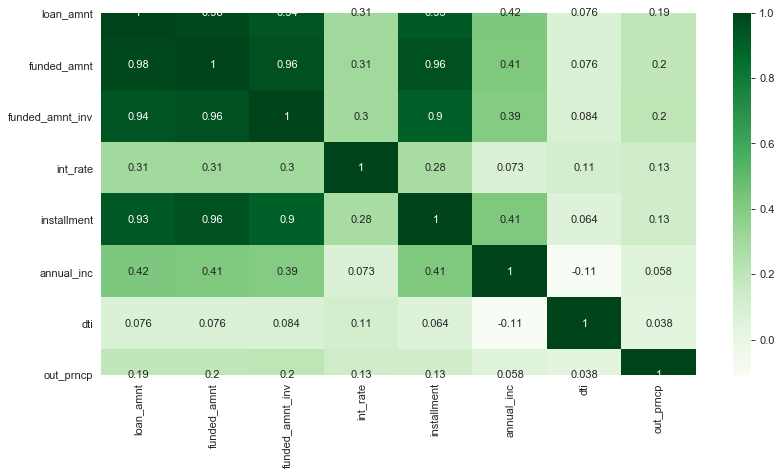

In [63]:
plt.figure(num=None,figsize=(12,6),dpi=80)

corrHeatmap=sns.heatmap(CorrMatrix,annot= True,cmap="Greens")

plt.show()

#### loan_amnt, funded_amnt , funded_amnt_inv and installment are highly coorelated .

In [64]:
# color_from_values assigns darker color to higher values 
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

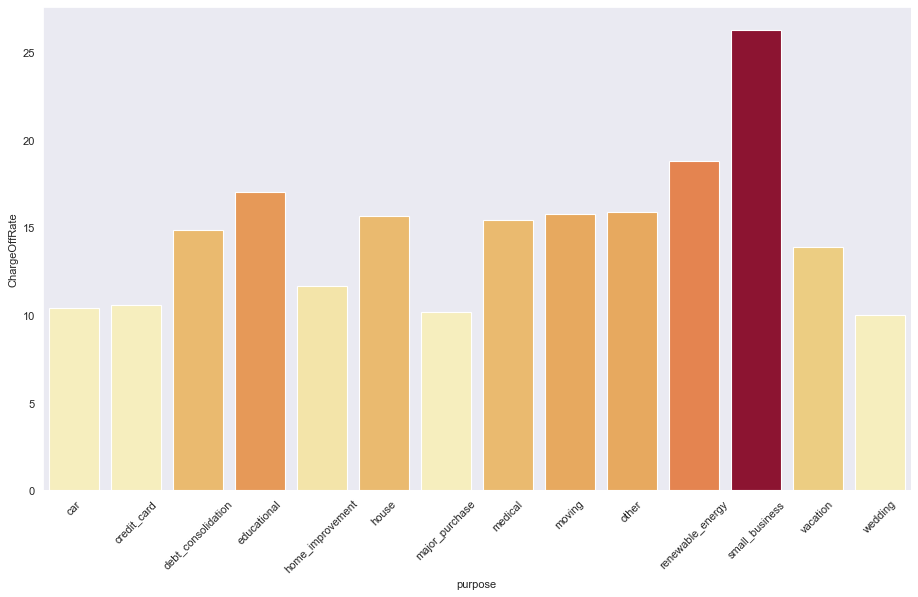

In [65]:

# Analyze purpose to charge of ratio
purpose_group = loans_df_cleaned.pivot_table(index='purpose', columns='loan_status', values='loan_amnt',aggfunc="count", fill_value=0).reset_index()
purpose_group[['Charged Off','Current','Fully Paid']].apply(pd.to_numeric, errors='coerce', axis=1)
purpose_group['ChargeOffRate'] = purpose_group['Charged Off'].div(purpose_group[['Charged Off','Current','Fully Paid']].sum(1), axis=0) *100
purpose_group = purpose_group[purpose_group['ChargeOffRate'] >0]
purpose_group

fig, ax1 = plt.subplots(figsize=(14,8),dpi=80)
bar = sns.barplot(x='purpose', y='ChargeOffRate', data = purpose_group, palette=colors_from_values(purpose_group['ChargeOffRate'], "YlOrRd"))
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)

#show plot
plt.show()

#### As per above chart , loan with purpose as small_business has higer chance of default

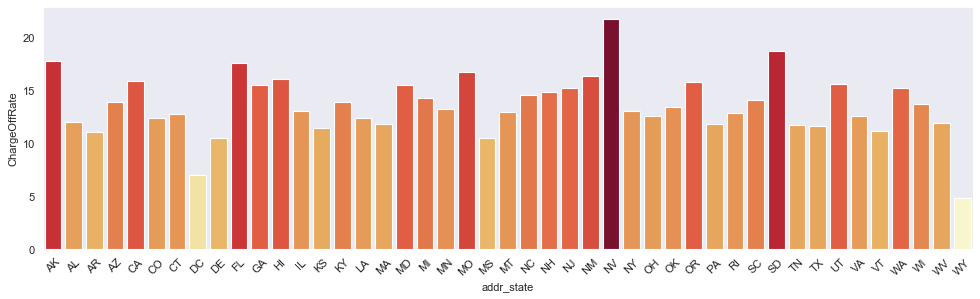

In [66]:
# Analyze state to charge of ratio

state_group = loans_df_cleaned.pivot_table(index='addr_state', columns='loan_status', values='loan_amnt',aggfunc="count", fill_value=0).reset_index()
state_group[['Charged Off','Current','Fully Paid']].apply(pd.to_numeric, errors='coerce', axis=1)
state_group['ChargeOffRate'] = state_group['Charged Off'].div(state_group[['Charged Off','Current','Fully Paid']].sum(1), axis=0) *100
state_group = state_group[(state_group[['Charged Off','Current','Fully Paid']].sum(1) > 10) & (state_group['ChargeOffRate'] > 0)]
state_group
fig, bar = plt.subplots(figsize=(15,4),dpi=80)

bar = sns.barplot(x='addr_state', y='ChargeOffRate', data = state_group,palette=colors_from_values(state_group['ChargeOffRate'], "YlOrRd"),ax=bar)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar = ax1.twinx()



#show plot
plt.show()

#### As per above chart , AK , NV and SD have higher number of defaulters.

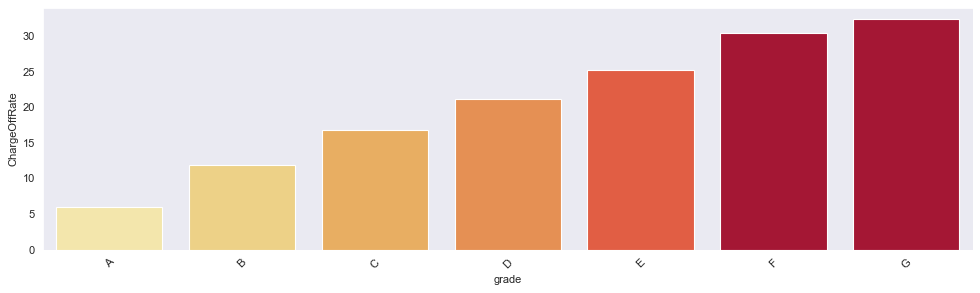

In [67]:
# Analyze Grade to charge of ratio

grade_group = loans_df_cleaned.pivot_table(index='grade', columns='loan_status', values='loan_amnt',aggfunc="count", fill_value=0).reset_index()
grade_group[['Charged Off','Current','Fully Paid']].apply(pd.to_numeric, errors='coerce', axis=1)
grade_group['ChargeOffRate'] = grade_group['Charged Off'].div(grade_group[['Charged Off','Current','Fully Paid']].sum(1), axis=0) *100
grade_group=grade_group[(grade_group[['Charged Off','Current','Fully Paid']].sum(1) > 10) & (grade_group['ChargeOffRate'] > 0)]
grade_group
fig, bar = plt.subplots(figsize=(15,4),dpi=80)

bar = sns.barplot(x='grade', y='ChargeOffRate', data = grade_group,palette=colors_from_values(grade_group['ChargeOffRate'], "YlOrRd"),ax=bar)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar = ax1.twinx()



#show plot
plt.show()

#### Higher the grade , higer the probability of default 

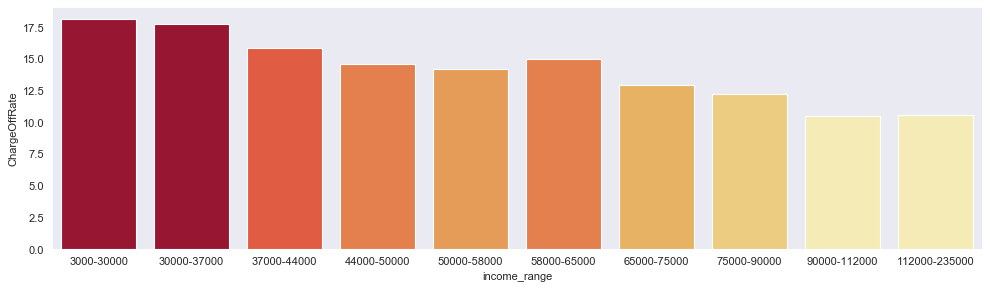

In [68]:
# Income to charge of ratio
# def binSeprator(x):
    
    
loans_df_cleaned['income_range'] = pd.qcut(loans_df_cleaned['annual_inc'], q=10,precision=-3)
loans_df_cleaned
pattern = '|'.join(['\(', ']'])
loans_df_cleaned['income_range'] = loans_df_cleaned['income_range'].astype(str).str.replace(pattern, '').str.replace(', ', '-').str.replace('\.0', '')
loans_df_cleaned['income_range']

income_group=loans_df_cleaned.pivot_table(index = 'income_range', columns='loan_status', values='loan_amnt',aggfunc="count", fill_value=0).reset_index()
income_group[['Charged Off','Current','Fully Paid']].apply(pd.to_numeric, errors='coerce', axis=1)
income_group['ChargeOffRate'] = income_group['Charged Off'].div(income_group[['Charged Off','Current','Fully Paid']].sum(1), axis=0) *100
income_group = income_group[(income_group[['Charged Off','Current','Fully Paid']].sum(1) > 10) & (income_group['ChargeOffRate'] > 0)]
income_group['upperRange'] = income_group.income_range.str.split('-').str[-1]
income_group["upperRange"] = pd.to_numeric(income_group["upperRange"]) 
income_group = income_group.sort_values(by=['upperRange'],ascending=True)

fig, bar = plt.subplots(figsize=(15,4),dpi=80)

bar = sns.barplot(x='income_range', y='ChargeOffRate', data = income_group,palette=colors_from_values(income_group['ChargeOffRate'], "YlOrRd"),ax=bar)
# bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar = ax1.twinx()



#show plot
plt.show()

#### Lower the income group , higher is the chance of default

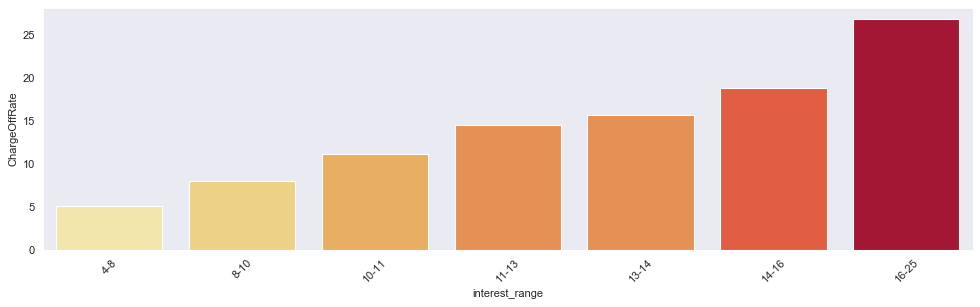

In [69]:
# Analyze interest to charge of ratio

loans_df_cleaned["int_rate"]=pd.to_numeric(loans_df_cleaned["int_rate"]) 
loans_df_cleaned['interest_range']=pd.qcut(loans_df_cleaned['int_rate'], q=7,precision=-3)
loans_df_cleaned
pattern = '|'.join(['\(', ']'])
loans_df_cleaned['interest_range']=loans_df_cleaned['interest_range'].astype(str).str.replace(pattern, '').str.replace(', ', '-').str.replace('\.0', '')
loans_df_cleaned['interest_range']


interest_group=loans_df_cleaned.pivot_table(index='interest_range', columns='loan_status', values='loan_amnt',aggfunc="count", fill_value=0).reset_index()
interest_group['upperRange'] = interest_group.interest_range.str.split('-').str[-1]
interest_group["upperRange"]=pd.to_numeric(interest_group["upperRange"]) 

interest_group=interest_group.sort_values(by=['upperRange'],ascending=True)
interest_group[['Charged Off','Current','Fully Paid']].apply(pd.to_numeric, errors='coerce', axis=1)
interest_group['ChargeOffRate'] = interest_group['Charged Off'].div(interest_group[['Charged Off','Current','Fully Paid']].sum(1), axis=0) *100
interest_group=interest_group[(interest_group[['Charged Off','Current','Fully Paid']].sum(1) > 10) & (interest_group['ChargeOffRate'] > 0)]
fig, bar = plt.subplots(figsize=(15,4),dpi=80)

bar = sns.barplot(x='interest_range', y='ChargeOffRate', data = interest_group,palette=colors_from_values(interest_group['ChargeOffRate'], "YlOrRd"),ax=bar)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar = ax1.twinx()



#show plot
plt.show()

#### Higher the interest rate , higher is the chance of default ( coorealtes with the logic -> higher the grade , higer is the probability of default)

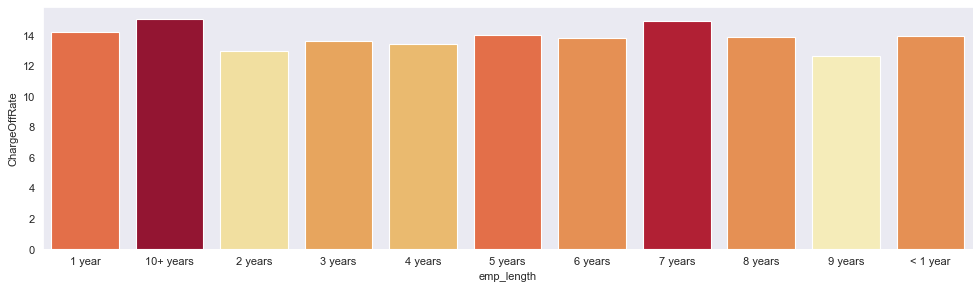

In [70]:
# Analyze emp_length to charge of ratio

employement_length_group = loans_df_cleaned.pivot_table(index='emp_length', columns='loan_status', values='loan_amnt',aggfunc="count", fill_value=0).reset_index()

employement_length_group[['Charged Off','Current','Fully Paid']].apply(pd.to_numeric, errors='coerce', axis=1)
employement_length_group['ChargeOffRate'] = employement_length_group['Charged Off'].div(employement_length_group[['Charged Off','Current','Fully Paid']].sum(1), axis=0) *100
employement_length_group=employement_length_group[(employement_length_group[['Charged Off','Current','Fully Paid']].sum(1) > 10) & (employement_length_group['ChargeOffRate'] > 0)]
fig, bar = plt.subplots(figsize=(15,4),dpi=80)

bar = sns.barplot(x='emp_length', y='ChargeOffRate', data = employement_length_group,palette=colors_from_values(employement_length_group['ChargeOffRate'], "YlOrRd"),ax=bar)
# bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar = ax1.twinx()



#show plot
plt.show()

[0, 10, 20, 30]


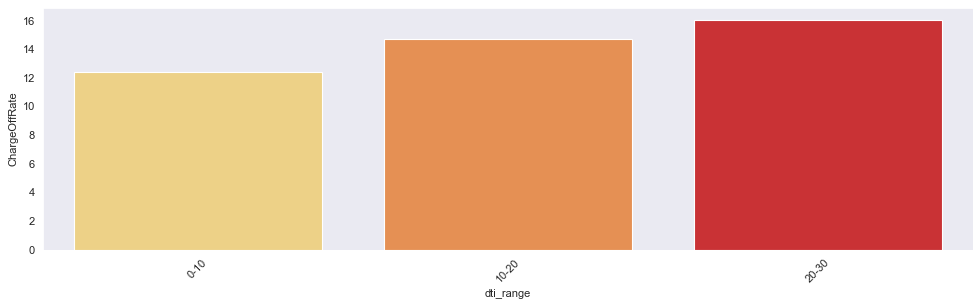

In [71]:
# Analyze DTI to charge of ratio
loans_df_cleaned["dti"]=pd.to_numeric(loans_df_cleaned["dti"]) 
# loans_df_cleaned['dti_range']=pd.qcut(loans_df_cleaned['dti'],q=7,precision=-3)
# loans_df_cleaned['dti_range']

# Using manual binning as qcut is returing negative value due to its internak issue
import pandas.core.algorithms as algos
bins = list(range(0, 40, 10))
print(bins)
labels = pd.Categorical(pd.core.reshape.tile._format_labels(algos.unique(bins), precision=0), 
                                 ordered=True)

labels

loans_df_cleaned['dti_range'] = pd.cut(loans_df_cleaned["dti"], bins,
                                labels=labels,
                                include_lowest=True)
loans_df_cleaned['dti_range']

pattern = '|'.join(['\(', ']'])
loans_df_cleaned['dti_range']=loans_df_cleaned['dti_range'].astype(str).str.replace(pattern, '').str.replace(', ', '-').str.replace('\.0', '')
loans_df_cleaned['dti_range']


dti_group=loans_df_cleaned.pivot_table(index='dti_range', columns='loan_status', values='loan_amnt',aggfunc="count", fill_value=0).reset_index()
dti_group['upperRange'] = dti_group.dti_range.str.split('-').str[-1]
dti_group["upperRange"]=pd.to_numeric(dti_group["upperRange"]) 

dti_group=dti_group.sort_values(by=['upperRange'],ascending=True)
dti_group[['Charged Off','Current','Fully Paid']].apply(pd.to_numeric, errors='coerce', axis=1)
dti_group['ChargeOffRate'] = dti_group['Charged Off'].div(dti_group[['Charged Off','Current','Fully Paid']].sum(1), axis=0) *100
dti_group=dti_group[(dti_group[['Charged Off','Current','Fully Paid']].sum(1) > 10) & (dti_group['ChargeOffRate'] > 0)]
fig, bar = plt.subplots(figsize=(15,4),dpi=80)

bar = sns.barplot(x='dti_range', y='ChargeOffRate', data = dti_group,palette=colors_from_values(dti_group['ChargeOffRate'], "YlOrRd"),ax=bar)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
bar = ax1.twinx()



#show plot
plt.show()

#### Higher the dti  , more is the chance of defaulting .